In [106]:
#!pip install bootstrapped

In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats
from scipy.stats import pearsonr, chi2, kstest, levene, ttest_ind
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [108]:
data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Выбор данных для анализа
Для проведения тестирования необходимо 

1) сформулировать несколько основных гипотез, которые необходимо будет проверить;

2) Выбрать переменные, которые будут необходимы для проведения проверки выбранных гипотез;

3) Выбрать метрики, необходимые для проведения тестирования; 

In [109]:
print(f'Shape of data:{data.shape}\n')
print(f'Types of variables:\n {data.dtypes.unique()}\n')

Shape of data:(1460, 81)

Types of variables:
 [dtype('int64') dtype('O') dtype('float64')]



In [110]:
cat_cols = list(data.select_dtypes(include=['object']).columns)
num_cols = list(data.select_dtypes(include=['int64', 'float64']))
print(f'Numeric columns:\n {list(num_cols)}\n')
print(f'Categorial columns:\n {cat_cols}\n')

Numeric columns:
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Categorial columns:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fireplace

#### Целевой переменной в данной задаче является переменная 'SalePrice' характеризующая конечную цену дома;


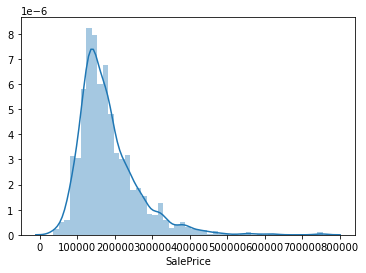

In [111]:
sns.distplot(data['SalePrice'])

### Еще одним интересным наблюдением является наличие большого количества переменных, связанный с площадью тех или иных участков дома. Их можно объединить в одну переменную:

In [112]:
area = []

for name in num_cols:
    if 'Area' in name or 'SF' in name:
        area.append(name)

print(f'Переменные, характеризующие площадь участков домов:\n{area}')

Переменные, характеризующие площадь участков домов:
['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']


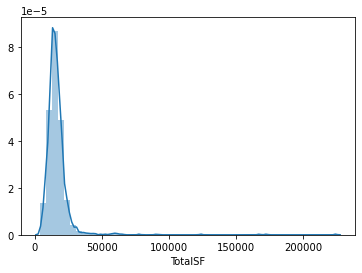

In [113]:
data['TotalSF'] = data[area].sum(axis=1)

sns.distplot(data['TotalSF'])
plt.show()

#### Соответственно, возникает идея о проверке самой простой гипотезы:

## H0: Цена дома не зависит от общей площади участка

## H1: существует взаимосвязь между ценой дома и площадью дома

#### Проверять гипотезу будем с помощью корреляционного анализа. Корреляционный анализ - метод, позволяющий обнаружить зависимость между несколькими случайными величинами.

Корреляционный анализ решает две основные задачи:

1) Первая задача заключается в определении формы связи, т.е. в установлении математической формы, в которой выражается данная связь. Это очень важно, так как от правильного выбора формы связи зависит конечный результат изучения взаимосвязи между признаками.

2) Вторая задача состоит в измерении тесноты, т.е. меры связи между признаками с целью установить степень влияния данного фактора на результат. Она решается математически путем определения параметров корреляционного уравнения.

Для определения наличия взаимосвязи между двумя свойствами используется коэффициент корреляции Пирсона:
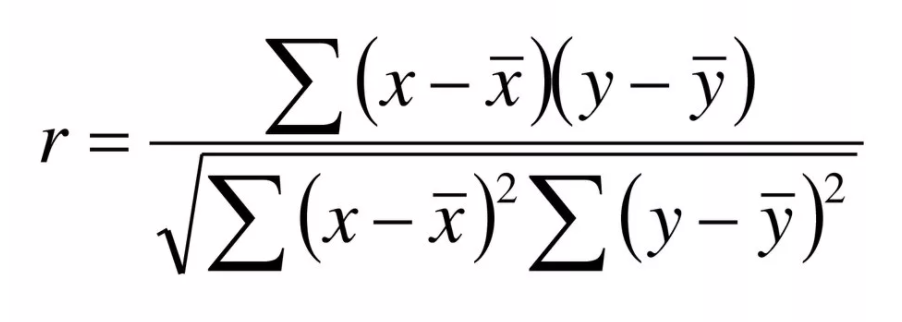




In [114]:
r = pearsonr(data['TotalSF'], data['SalePrice'])[0]

print(f'Коэффициент корреляции Пирсона: {r}')

Коэффициент корреляции Пирсона: 0.39135985477119434


#### Для харатеристики тесноты связи используем шкалу Чеддока:
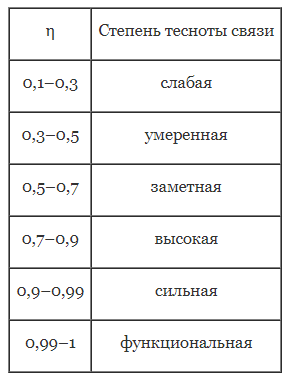
### Тип тесноты связи для переменных 'TotalSF' и 'SalePrice' - умеренная

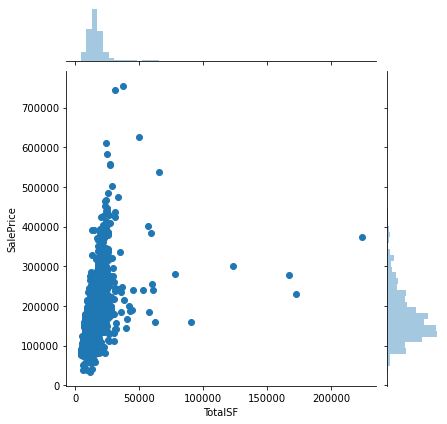

In [115]:
sns.jointplot(x='TotalSF', y='SalePrice', data=data, kind='scatter');

### Проверка гипотезы:

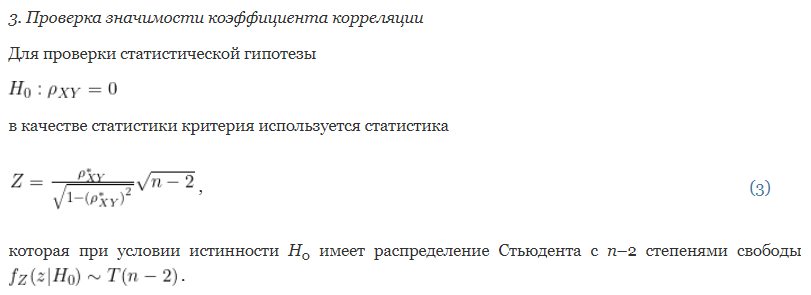

In [116]:
alpha = 0.01

p_value = pearsonr(data['TotalSF'], data['SalePrice'])[1]

print(f"Данные {['не', ''][p_value < alpha]}зависимы друг от друга")

Данные зависимы друг от друга


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """


### Гипотеза H0 отвергнута => была принята альтернативная гипотеза о наличии связи между переменными "TotalSF" и "SalePrice"

================================================================================================================================================

#### Вторая гипотеза - о зависимости изменения уровня качества домов (характеристикой чего является рейтинг, выставленный домом 'OverallCond') от  общей площади дома:

## H0: Качество дома не зависит от его площади

## H1: Существует взаимосвязь между выставленным дому рейтингом и площадью дома

#### Проверять гипотезу будем с помощью дисперсионного анализа.
### Сначала сгруппируем оценки на несколько классов:

In [117]:
data['Rating'] = np.where(data['OverallCond'] <= 4,'low',
                             np.where( (4 < data['OverallCond']) & (data['OverallCond'] < 7),'middle', 'high'))
data['Rating'].value_counts()

middle    1073
high       299
low         88
Name: Rating, dtype: int64

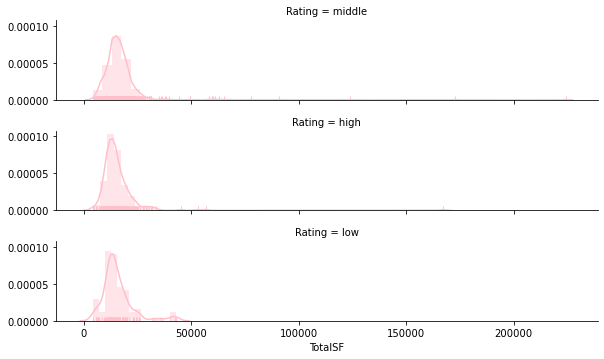

In [118]:
g = sns.FacetGrid(data, row="Rating",
                  height=1.7, aspect=5)
g.map(sns.distplot, "TotalSF", hist=True, rug=True, color = 'pink')

### Для применения ANOVA необходимо нормальное распределение выборок, но уже на стадии рассмотрения графиков можно понять, что данные в выборках не распределены нормально. Следовательно, необходимо сформировать новые выборки, используя метод bootstrap:

In [141]:
rateLowSF = bs.bootstrap(data[data['Rating'] == 'low']['TotalSF'].values, stat_func=bs_stats.median, 
             num_iterations=1000, iteration_batch_size=20, 
             return_distribution=True)

rateMiddleSF = bs.bootstrap(data[data['Rating'] == 'middle']['TotalSF'].values, stat_func=bs_stats.median, 
             num_iterations=1000, iteration_batch_size=20, 
             return_distribution=True)

rateHighSF = bs.bootstrap(data[data['Rating'] == 'high']['TotalSF'].values, stat_func=bs_stats.median, 
             num_iterations=1000, iteration_batch_size=20, 
             return_distribution=True)

### И можем еще раз посмотреть на полученные распределения:

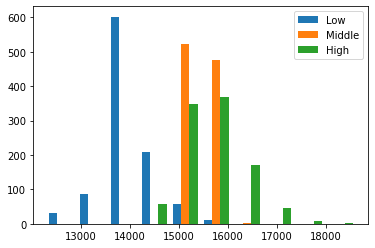

In [142]:
plt.hist([rateLowSF, rateMiddleSF, rateHighSF], bins=10, label=['Low', 'Middle', 'High'])
plt.legend()
plt.show()

### Кроме того, необходимо проверить равенство дисперсий в выборках. Для этого будем использовать тест Левена, преимущества которого я описал в прошлом проекте.
https://colab.research.google.com/drive/1yAcdGAqXnv5Kw5HVJ5y1ZhfkfPBzxJnE?usp=sharing

In [143]:
levene(rateLowSF, rateMiddleSF, rateHighSF)[1]

2.484596206105564e-129

In [122]:
rates = np.sort(data['OverallCond'].unique())

observed = []
for rat in years:
    row = []
    for rate in rates:
        row.append(data[(data['YearBuilt'] == year) & (data['OverallCond'] == rate)].shape[0])
    observed.append(row)

observed = pd.DataFrame(observed, index=years, columns=rates)
observed.loc[:, 'Всего'] = observed.sum(axis=1)

observed.loc['Всего']= observed.sum()

print("Таблица сопряженности | observed:")
print(observed)

Таблица сопряженности | observed:
       1    2  3  4  5  6  7  8  9  Всего
1872   0    1  0  0  0  0  0  0  0      1
1875   0    1  0  0  0  0  0  0  0      1
1880   0    1  0  0  0  0  0  0  0      1
1882   0    1  0  0  0  0  0  0  0      1
1885   0    1  0  0  0  0  0  0  0      1
...   ..  ... .. .. .. .. .. .. ..    ...
2007   0    1  0  0  0  0  0  0  0      1
2008   0    1  0  0  0  0  0  0  0      1
2009   0    1  0  0  0  0  0  0  0      1
2010   0    1  0  0  0  0  0  0  0      1
Всего  0  112  0  0  0  0  0  0  0    112

[113 rows x 10 columns]


In [123]:
expected = []
for i in range(observed.shape[0] - 1):
    row = []
    for j in range(observed.shape[1] - 1):
        row.append(observed.iloc[i, -1] * observed.iloc[-1, j] / observed.iloc[-1, -1])
    expected.append(row)
        
expected = pd.DataFrame(expected, index=years, columns=rates)
print("Таблица сопряженности | expected:")
print(expected)

Таблица сопряженности | expected:
        1    2    3    4    5    6    7    8    9
1872  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1875  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1880  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1882  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1885  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...
2006  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2007  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2008  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2009  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2010  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[112 rows x 9 columns]


### Для того, чтобы проверить нашу гипотезу, используем критерий хи-квадрат:
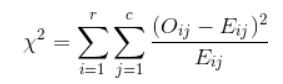

In [124]:
stats = 0
df = (expected.shape[0] - 1) * (observed.shape[1] - 1)

for i in range(expected.shape[0]):
    for j in range(expected.shape[1]):
        stats += (observed.iloc[i,j] - expected.iloc[i,j])**2 / expected.iloc[i,j]

p_value = chi2.sf(stats, df)

print(f"Статистика: {stats}\nP-value: {p_value}")

Статистика: nan
P-value: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [125]:
alpha = 0.01

print('Данные {}зависимы друг от друга'.format( {True:'',
False:'не '}[p_value < alpha]))

Данные не зависимы друг от друга


### То есть по результатам данных имеется некоторая закономерность в изменении выставленного рейтинга для построенных домов от года его строительства
#### Проиллюстрируем это на графике:

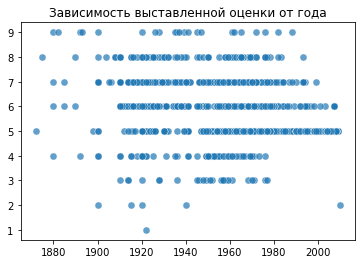

In [126]:
plt.scatter(data['YearBuilt'], data['OverallCond'], s=50, alpha=.7, linewidth=.5, edgecolor="white")
plt.title('Зависимость выставленной оценки от года')
plt.show()

================================================================================================================================================

#### Третья гипотеза - о сравнении средних цен за квадратный фут площади квартиры за 2005 и 2006 год
## H0: Средние цены квадратного фута дома за 2005 и 2006 год одинаковы

## H1: Существует разница между между ценой квадратного фута дома за 2005 и 2006 года
### Выбранная метрика:

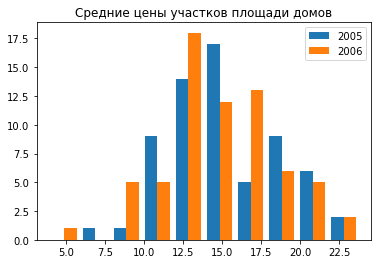

In [127]:
data['AvgPriceSF'] = data['SalePrice'] / data['TotalSF']

avgprice5 = data[data['YearBuilt'] == 2005]['AvgPriceSF']
avgprice6 = data[data['YearBuilt'] == 2006]['AvgPriceSF']

plt.hist([avgprice5, avgprice6], label=['2005', '2006'])
plt.title('Средние цены участков площади домов')
plt.legend()
plt.show()

### Для того, чтобы решить, какой метод проверки выбрать t-test или bootstrap, необходимо проверить выборки на нормальность.
#### Критерий Колмогорова-Смирнова:

In [128]:
alpha = 0.01

p_value = kstest(avgprice5, 'norm')[1]
print('Распределение данных за 2005 год {}нормальное'.format( {True:'не ',
False:''}[p_value < alpha]))

p_value = kstest(avgprice6, 'norm')[1]
print('Распределение данных за 2006 год {}нормальное'.format( {True:'не ',
False:''}[p_value < alpha]))

Распределение данных за 2005 год не нормальное
Распределение данных за 2006 год не нормальное


In [136]:
kstest(data['TotalSF'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

### Исходя из вышеуказанных результатов следует, что лучше применить метод bootstrap для формирования нормально распределенных выборок
#### Для начала необходимо определить оптимальный объем выборок:

In [129]:
effect = 0.1
alpha = 0.01
power = 0.9
# perform power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect, power=power,
nobs1=None, ratio=1.0, alpha=alpha)

print('Оптимальный объем выборки: {0:.2f}'.format(sample_size))

Оптимальный объем выборки: 2977.54


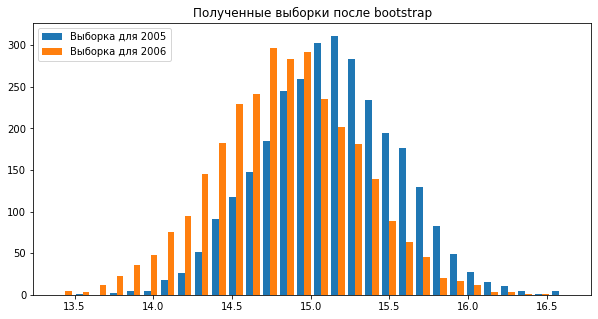

In [130]:
metric5 = bs.bootstrap(avgprice5.values, stat_func=bs_stats.mean, 
             num_iterations=sample_size, iteration_batch_size=20, 
             return_distribution=True)

metric6 = bs.bootstrap(avgprice6.values, stat_func=bs_stats.mean, 
             num_iterations=sample_size, iteration_batch_size=20, 
             return_distribution=True)

plt.figure(figsize=(10,5))
plt.hist([metric5, metric6], bins = 30, label=['Выборка для 2005', 'Выборка для 2006'])
plt.legend(loc='upper left')
plt.title('Полученные выборки после bootstrap')
plt.show()

### Проверка равенства дисперсий для проведения t-test:

In [131]:
alpha = 0.01

p_value = levene(avgprice5, avgprice6, center='median')[1]

print('Стандартные отклонения {}одинаковы'.format( {True:'не ',
False:''}[p_value < alpha]))

Стандартные отклонения одинаковы


In [132]:
alpha = 0.05
stats, p_value = ttest_ind(metric5, metric6)

print('Статистика t-test:', stats)
print('P-value для t-test:', p_value)
print('Статистическая разница {}значима'.format({True: '', False: 'не'}[p_value < alpha]))

Статистика t-test: 25.758749642995486
P-value для t-test: 8.18578292713192e-139
Статистическая разница значима


### После этого можно применить t-test для проверки значимости разности между выбранными метриками:

## Тест показал, что средняя цена квадратного фута изменилась. В какую сторону? Можно сравнить данные по box and whisker plot:

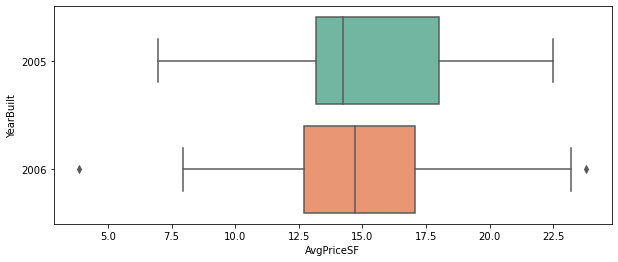

In [133]:
plt.figure(figsize=(10,4))
sns.boxplot(x = 'AvgPriceSF', y='YearBuilt', data=data[(data['YearBuilt']==2005) | (data['YearBuilt']==2006)], orient="h", palette = 'Set2')
plt.show()

### По графику видно, что средняя цена за квадратный фут увеличилась к 2006 году. И представляет с собой:

In [134]:
print('Цена одного квадратного фута:', metric6.mean())

Цена одного квадратного фута: 14.831431497643397
